## BigDL Visualization on Tensorboard

**Problem Statement**

MNIST dataset to train a lenet-5 model, and visualize this training using jupyter and tensorboard.

In [1]:
#import packages
import matplotlib
matplotlib.use('Agg')
%pylab inline
import datetime as dt
import tempfile
import sys
import os
from utils import get_mnist
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext
from IPython.display import Markdown, display
#Creating Spark Context
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib
Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


In [2]:
#Setting the path for Spark
os.environ['JAVA_HOME']="/usr/lib/jvm/java-8-oracle"
os.environ['SPARK_HOME'] = "/home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['HADOOP_HOME'] = "/usr/local/hadoop/bin"
os.environ['YARN_CONF_DIR'] = "/usr/local/hadoop/etc/hadoop"
os.environ['BIGDL_HOME'] = "/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/bin"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/kunal/Downloads/jarfiles/bigdl-SPARK_2.2-0.7.0-jar-with-dependencies.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.3 pyspark-shell'

### Train 

In [5]:
# Get and store MNIST into RDD of Sample
mnist_path = "./data/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print(train_data.count())
print(test_data.count())

9912320/9912422 [============================>.] - ETA: 0sSuccessfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting datasets/mnist/train-images-idx3-ubyte.gz
16384/28881 [================>.............] - ETA: 0sSuccessfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
1638400/1648877 [============================>.] - ETA: 0sSuccessfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
8192/4542 [======================================================] - 0s
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
60000
10000


In [6]:
# Create a LeNet-5 model
def build_model(class_num):
    input = Reshape([1, 28, 28]).set_name("reshape_1_28_28")()
    conv1 = SpatialConvolution(1, 6, 5, 5).set_name("conv1_5x5")(input)
    tanh1 = Tanh().set_name("tanh1")(conv1)
    pool1 = SpatialMaxPooling(2, 2, 2, 2).set_name("pool1_2x2")(tanh1)
    tanh2 = Tanh().set_name("tanh2")(pool1)
    conv2 = SpatialConvolution(6, 12, 5, 5).set_name("conv2_5x5")(tanh2)
    pool2 = SpatialMaxPooling(2, 2, 2, 2).set_name("pool2_2x2")(conv2)
    reshape = Reshape([12 * 4 * 4]).set_name("reshape_192")(pool2)
    fc1 = Linear(12 * 4 * 4, 100).set_name("fc_192_100")(reshape)
    tanh3 = Tanh().set_name("tanh3")(fc1)
    fc2 = Linear(100, class_num).set_name("fc_100_" + str(class_num))(tanh3)
    output = LogSoftMax().set_name("classifier")(fc2)

    model = Model(input, output)
    return model
lenet_model = build_model(10)

creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax
creating: createModel


In [7]:
# Create an Optimizer
optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=0.4, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(5),
    batch_size=256)

# Set the validation logic
optimizer.set_validation(
    batch_size=256,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy(), Loss()]
)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.
  warnings.warn("You are recommended to use `create` method to create an optimizer.")


**Note:**

Will create a TrainSummary and a ValSummary and set them to Optimizer to enable metrics collecting. By default, BigDL only collect throughput, loss, and validation result during the Training. We can use 
`train_summary.set_summary_trigger` to enable more metrics, like `Parameters` and `LearningRate`.

In [8]:
#creating Log directory
log_dir=tempfile.mkdtemp() # use a tmp folder
app_name='lenet-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")

In [9]:
# create TrainSummary
train_summary = TrainSummary(log_dir=log_dir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
train_summary.set_summary_trigger("LearningRate", SeveralIteration(1))

creating: createTrainSummary
creating: createSeveralIteration
creating: createSeveralIteration


JavaObject id=o201

In [10]:
# create ValSummary
val_summary = ValidationSummary(log_dir=log_dir, app_name=app_name)
# set TrainSummary and ValSummary to 
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)

creating: createValidationSummary


In [11]:
print("Will saving logs to",log_dir + "/" + app_name)
display(Markdown("You can run shell command, **tensorboard --logdir=%s**, to visualize this training" % log_dir))

Will saving logs to /tmp/tmp1400sz2q/lenet-20210104-212158


You can run shell command, **tensorboard --logdir=/tmp/tmp1400sz2q**, to visualize this training

In [14]:
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.


### Visualization

In [17]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir=/tmp/tmp1400sz2q

* You can also use `Model.save_graph_topology` method to save graph's topology, and visualize the graph in TensorBoard.

In [19]:
lenet_model.save_graph_topology(log_dir + "/" + app_name + "/lenet-model")
print("Saving graph topology to", log_dir + "/" + app_name + "/lenet-model")

Saving graph topology to /tmp/tmp1400sz2q/lenet-20210104-212158/lenet-model


In [20]:
#visualize the graph in TensorBoard
%tensorboard --logdir=/tmp/tmp1400sz2q/lenet-20210104-212158/lenet-model

Text(0.5,1,'top1 accuracy')

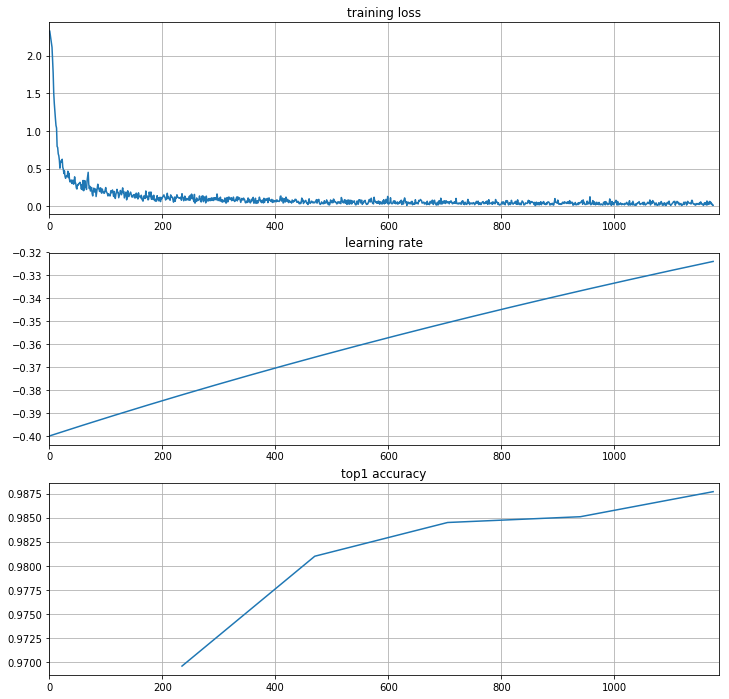

In [21]:
#Train and Validation Summary using Matplotlib
loss = np.array(train_summary.read_scalar("Loss"))
lr = np.array(train_summary.read_scalar("LearningRate"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(3,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("training loss")

plt.subplot(3,1,2)
plt.plot(lr[:,0],lr[:,1],label='lr')
plt.xlim(0,lr.shape[0]+10)
plt.title("learning rate")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("top1 accuracy")